# ASAXS data reduction

some script description

## Libraries

In [109]:
import pandas as pd
import os
import csv
import time

import numpy as np
from scipy import optimize
import scipy.integrate as integrate
import scipy.constants as con
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap

import fabio
import pyFAI
from pyFAI.detectors import Pilatus1M

## Fuctions

In [126]:
cdict = {'red':   ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),
          
         'alpha': ((0.0, 0.0, 0.0),
                   (1.0, 0.7, 0.7))
         }
red_alpha = LinearSegmentedColormap('red_alpha', cdict)
plt.register_cmap(cmap=red_alpha)

## Read the basic data

In [131]:
# give the directory
data_dir = 'files\Data_for_ASAXS'
# name if data file ontaining all nessesary information
metaFileName = 'Data_for_ASAXS_ASCII_out_changed_test.txt'
pathTo_ReferenceFile = 'files\GC-Calibration_Final\GC-K_54um-c.dat'

# For the azimuthal integration result
bin_number = 400 #how many data points are generated in 1D curves
pixelsize = 172e-6 #m
scale = 10  # upscaling of poisson error for visibility

#read the meta file
path_to_metaFile = data_dir + os.sep + metaFileName
metaFrame = pd.read_csv(path_to_metaFile, sep='\t',index_col=0)

# Define divice identifiers
sampleName = 'SampleName'
monitorDiode = 'Keysight4'
monitorDeviation = 'Keysight4:StandardDeviation'
transmissionDiode = 'Keysight1'
transmissionDeviation = 'Keysight1:StandardDeviation'
acquisitionTime = 'PilatusAcqTime'
sampleThickness = 'SampleThickness'
sampleName = 'SampleName'
xray_energy = 'Energy'
maskFileName = 'MaskFile'
x_Center_String = 'x_Center' # in pixel
y_Center_String = 'y_Center' # in pixel
sampleToDetectorDistance = 'SampleToDet_Distance' # in meter

[]

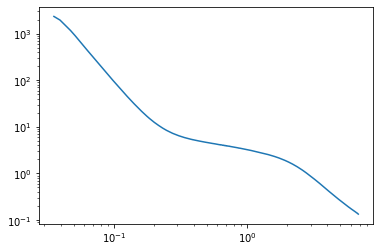

In [132]:
refData = np.genfromtxt(pathTo_ReferenceFile, delimiter=',',comments='#')
ref0_q = np.empty(0)
ref0_I = np.empty(0)
ref0_e = np.empty(0)
for i in range(refData.shape[0]):
    ref0_q = np.append(ref0_q,refData[i][0])
    ref0_I = np.append(ref0_I,refData[i][1])
    ref0_e = np.append(ref0_e,refData[i][2])
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.loglog()

## Data Handling

  File "<ipython-input-164-c08ad740f7bc>", line 132, in <module>
    detector=Pilatus1M(), wavelength=wavelength)


x_Center is 456.736 Reference is: pilatus_2020kw29tg14_00379.tif | Empty is: pilatus_2020kw29tg14_00378.tif
Reference Normalization between: 0.25783793930087684 nm^-1 and  1.150917351633363 nm^-1
Index for Reference file: 56 with 0.2565 nm^-1 to 259 with 1.1473 nm^-1
Index for Experimental Reference data: 9 with 0.25581373179742434 nm^-1 to 72 with 1.1440770668263258 nm^-1
known 3.705720409 experimental 13755479.46393196 factor 2.6939958136077445e-07


C:\Users\jlz\Anaconda\lib\site-packages\ipykernel_launcher.py:203: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


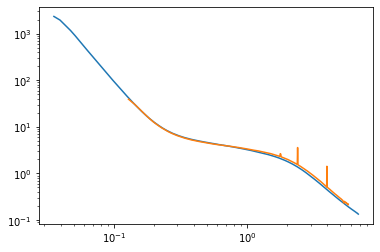

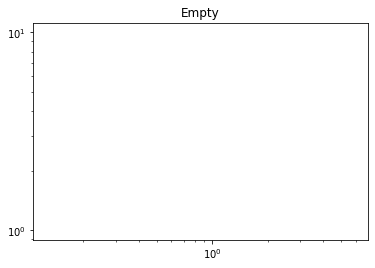

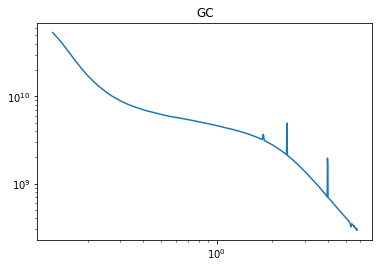

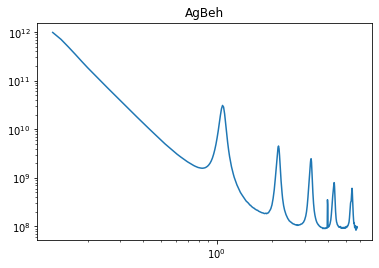

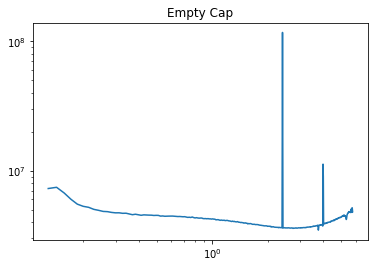

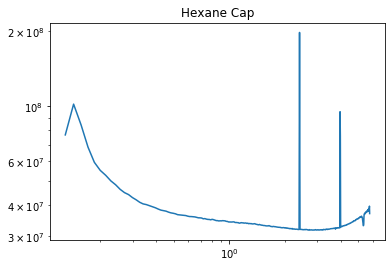

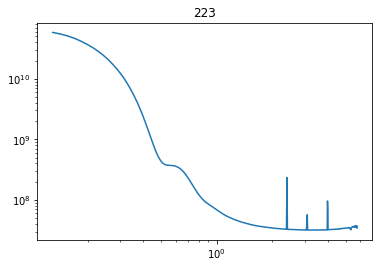

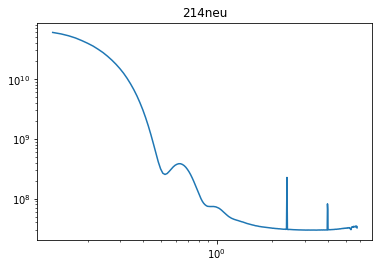

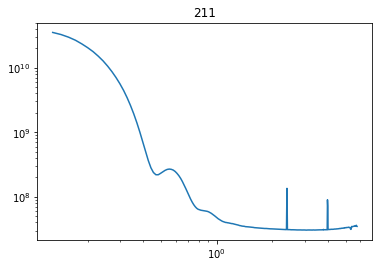

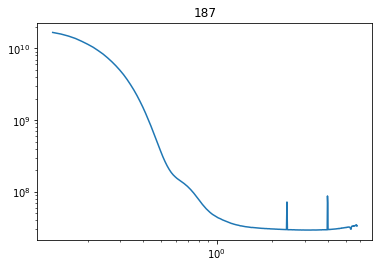

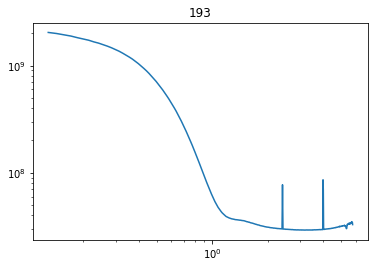

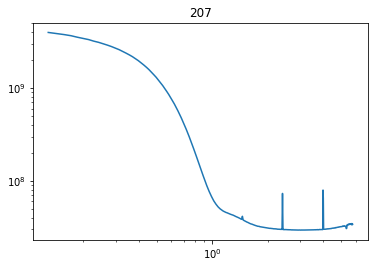

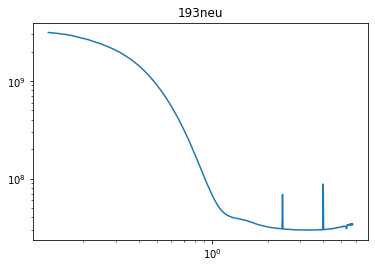

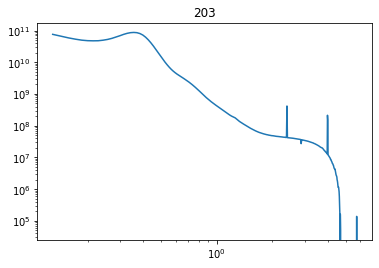

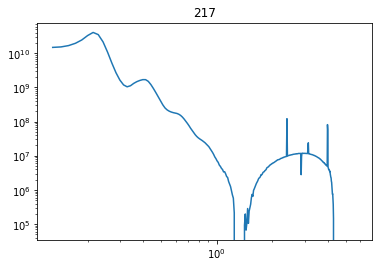

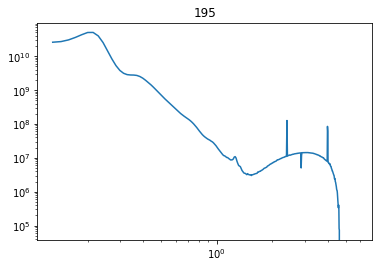

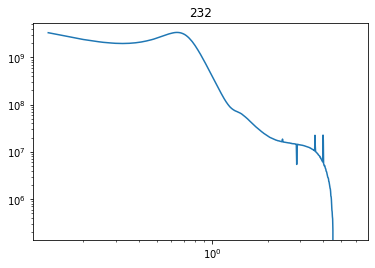

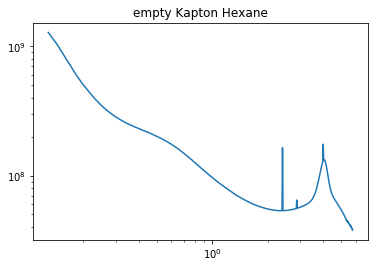

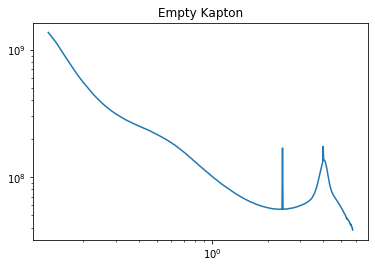

In [164]:
usedBackGr_index = 'False'
usedReference_index = 'False'
x_Center_old = 'False'
y_Center_old = 'False'
energy_old = 'False'
stDetDist_old = 'False'
maskFile_old = 'False'
correctionFrame = pd.DataFrame()

for element in metaFrame.index:
    # read the image
    tiffName = metaFrame['Pilatus_filename'][element].split('/')[-1]
    tiffPath = data_dir + os.sep + tiffName
    image_object = fabio.open(tiffPath)
    image = image_object.data
    
    # read values
    name = metaFrame[sampleName][element]
    monitorI = metaFrame[monitorDiode][element]
    transmI = metaFrame[transmissionDiode][element]
    monitorI_dev = metaFrame[monitorDeviation][element]
    transmI_dev = metaFrame[transmissionDeviation][element]
    acqTime = metaFrame[acquisitionTime][element]
    thickness = metaFrame[sampleThickness][element]
    energy = metaFrame[xray_energy][element]
    
    empty_monitorI = metaFrame[monitorDiode][metaFrame['Empty_Index'][element]]
    empty_transmI = metaFrame[transmissionDiode][metaFrame['Empty_Index'][element]]
    
    # calculate transmission
    image_transmission = (transmI/monitorI)/(empty_transmI/empty_monitorI)
    image_transmission_deviation = image_transmission * (monitorI_dev/monitorI + transmI_dev/transmI)
    #print(tiffName,'measured',acqTime,'sec with transmission:' , image_transmission, '+/-',image_transmission_deviation)
    
    # normalizing image
    image = image / monitorI / acqTime / image_transmission
    
    # loead the image background file
    if int(metaFrame['Background_Index'][element]) == usedBackGr_index:
        #print('stay')
        pass
    else:
        # read the BackGround image
        tiffName_BackGr = metaFrame['Pilatus_filename'][metaFrame['Background_Index'][element]].split('/')[-1]
        tiffPath_BackGr = data_dir + os.sep + tiffName_BackGr
        image_object_BackGr = fabio.open(tiffPath_BackGr)
        image_BackGr = image_object_BackGr.data
        usedBackGr_index = int(metaFrame['Background_Index'][element])
        
        # read BackGround values
        monitorI_BG = metaFrame[monitorDiode][usedBackGr_index]
        transmI_BG = metaFrame[transmissionDiode][usedBackGr_index]
        monitorI_BG_dev = metaFrame[monitorDeviation][usedBackGr_index]
        transmI_BG_dev = metaFrame[transmissionDeviation][usedBackGr_index]
        acqTime_BG = metaFrame[acquisitionTime][usedBackGr_index]
        empty_monitorI_BG = metaFrame[monitorDiode][metaFrame['Empty_Index'][usedBackGr_index]]
        empty_transmI_BG = metaFrame[transmissionDiode][metaFrame['Empty_Index'][usedBackGr_index]]
        
        # calculate BackGround transmission
        image_transmission_BG = (transmI_BG/monitorI_BG)/(empty_transmI_BG/empty_monitorI_BG)
        image_transmission_BG_deviation = image_transmission_BG * (monitorI_BG_dev/monitorI_BG + transmI_BG_dev/transmI_BG)
        
        # normalizing BackGround image
        image_BackGr = image_BackGr / monitorI_BG / acqTime_BG / image_transmission_BG
        #print(usedBackGr_index,'=',image_transmission_BG,'+/-',image_transmission_BG_deviation)
    
    # Subtract the scattering Background
    image = image - image_BackGr
    image = image/thickness
    
    # loead the image Reference file
    if int(metaFrame['Reference_Index'][element]) == usedReference_index:
        #print('stay')
        pass
    else:
        usedReference_index = int(metaFrame['Reference_Index'][element])
        # read the Reference image
        tiffName_Ref = metaFrame['Pilatus_filename'][metaFrame['Reference_Index'][usedReference_index]].split('/')[-1]
        tiffPath_Ref = data_dir + os.sep + tiffName_Ref
        image_object_Ref = fabio.open(tiffPath_Ref)
        image_Ref = image_object_Ref.data
        
        tiffName_Empty = metaFrame['Pilatus_filename'][metaFrame['Empty_Index'][usedReference_index]].split('/')[-1]
        tiffPath_Empty = data_dir + os.sep + tiffName_Ref
        image_object_Empty = fabio.open(tiffPath_Empty)
        image_Empty = image_object_Empty.data
        
        
        # read Reference values
        monitorI_Ref = metaFrame[monitorDiode][usedReference_index]
        transmI_Ref = metaFrame[transmissionDiode][usedReference_index]
        monitorI_Ref_dev = metaFrame[monitorDeviation][usedReference_index]
        transmI_Ref_dev = metaFrame[transmissionDeviation][usedReference_index]
        acqTime_Ref = metaFrame[acquisitionTime][usedReference_index]
        
        energy = metaFrame[xray_energy][usedReference_index]
        wavelength = con.h * con.c / con.e / energy  # m
        x_Center = metaFrame[x_Center_String][usedReference_index] #Reference
        y_Center = metaFrame[y_Center_String][usedReference_index] #Reference
        stDetDist = metaFrame[sampleToDetectorDistance][usedReference_index]
        maskFile = metaFrame[maskFileName][usedReference_index]
        
        
        empty_monitorI_Ref = metaFrame[monitorDiode][metaFrame['Empty_Index'][usedReference_index]]
        empty_transmI_Ref = metaFrame[transmissionDiode][metaFrame['Empty_Index'][usedReference_index]]
        empty_acqTime = metaFrame[acquisitionTime][metaFrame['Empty_Index'][usedReference_index]]
        
        # calculate Reference and Reference-BackGround transmission
        image_transmission_Ref = (transmI_Ref/monitorI_Ref)/(empty_transmI_Ref/empty_monitorI_Ref)
        image_transmission_Ref_deviation = image_transmission_Ref * (monitorI_Ref_dev/monitorI_Ref + transmI_Ref_dev/transmI)
        
        image_transmission_Empty = (empty_transmI_Ref/empty_monitorI_Ref)/(empty_transmI_Ref/empty_monitorI_Ref)
        
        
        # normalizing Reference image
        image_Ref = image_Ref / monitorI_Ref / acqTime_Ref / image_transmission_Ref
        image_Empty = image_Empty / empty_monitorI_Ref / empty_acqTime / image_transmission_Ref
        image_Ref = image_Ref - image_Empty
        
        print('x_Center is',x_Center,'Reference is:',tiffName_Ref,'| Empty is:', tiffName_Empty)
        
        if x_Center == x_Center_old and y_Center == y_Center_old and energy == energy_old and stDetDist == stDetDist_old and maskFile == maskFile_old:
            pass
        else:
            x_Center_old = x_Center
            y_Center_old = y_Center
            energy_old = energy
            stDetDist_old = stDetDist
            maskFile_old = maskFile
            
            ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,
                                   detector=Pilatus1M(), wavelength=wavelength)
            # adress the mask
            ai_mask_path = data_dir + os.sep + maskFile
            ai_mask_object = fabio.open(ai_mask_path)
            ai_mask = ai_mask_object.data
        
        #Do the azimutal integration of the Reference file
        ref_q, ref_I, ref_e = ai.integrate1d(image_Ref, bin_number, error_model='poisson', mask=ai_mask)
        
        # find integration limits for the Reference data
        q_Limit_min = np.array((ref0_q.min(),ref_q.min())).max()
        q_Limit_max = np.array((ref0_q.max(),ref_q.max())).min()
        q_normLimit_min = 2 * q_Limit_min
        q_normLimit_max = q_Limit_max - 0.8*q_Limit_max
        # find the index close to the limit
        ref0_IndexMin = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_min))
        ref0_IndexMax = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_max))
        ref_IndexMin = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_min))
        ref_IndexMax = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_max))
        
        print('Reference Normalization between:',q_normLimit_min,'nm^-1 and ',q_normLimit_max,'nm^-1')
        print('Index for Reference file:',ref0_IndexMin,'with',ref0_q[ref0_IndexMin],'nm^-1 to',ref0_IndexMax,'with',ref0_q[ref0_IndexMax],'nm^-1')
        print('Index for Experimental Reference data:',ref_IndexMin,'with',ref_q[ref_IndexMin],'nm^-1 to',ref_IndexMax,'with',ref_q[ref_IndexMax],'nm^-1')
        # Get the normalization/calibration factor
        int_Reference0 = integrate.trapz(y=ref0_I[ref0_IndexMin:ref0_IndexMax] ,x=ref0_q[ref0_IndexMin:ref0_IndexMax], axis=- 1)
        int_Reference = integrate.trapz(y=ref_I[ref_IndexMin:ref_IndexMax] ,x=ref_q[ref_IndexMin:ref_IndexMax], axis=- 1)
        calibrationFactor = int_Reference0/int_Reference
        print('known',int_Reference0,'experimental',int_Reference,'factor',calibrationFactor)
        # use calibration Factor on experimental reference data
        ref_I = ref_I * calibrationFactor
        ref_e = ref_e * calibrationFactor
        
        # plot measured and known Reference data
        fig, ax = plt.subplots()
        ax.plot(ref0_q, ref0_I)
        ax.fill_between(ref_q, ref_I + scale * ref_e, ref_I - scale * ref_e, alpha=0.5)
        ax.plot(ref_q, ref_I)
        ax.loglog()

    
    # Do the azimutal integration of the Reference file
    energy = metaFrame[xray_energy][element]
    wavelength = con.h * con.c / con.e / energy  # m
    x_Center = metaFrame[x_Center_String][element]
    y_Center = metaFrame[y_Center_String][element]
    stDetDist = metaFrame[sampleToDetectorDistance][element]
    maskFile = metaFrame[maskFileName][element]
    
    if x_Center == x_Center_old and y_Center == y_Center_old and energy == energy_old and stDetDist == stDetDist_old and maskFile == maskFile_old:
        pass
    else:
        x_Center_old = x_Center
        y_Center_old = y_Center
        energy_old = energy
        stDetDist_old = stDetDist
        maskFile_old = maskFile
    
        ai = pyFAI.AzimuthalIntegrator(dist=stDetDist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,
                               detector=Pilatus1M(), wavelength=wavelength)
        # adress the mask
        ai_mask_path = data_dir + os.sep + maskFile
        ai_mask_object = fabio.open(ai_mask_path)
        ai_mask = ai_mask_object.data
    
    # usage of integrate 1d method
    q, I, e = ai.integrate1d(image, bin_number, error_model='poisson', mask=ai_mask)
    
    fig, ax = plt.subplots()
    ax.fill_between(q, I + scale * e, I - scale * e, alpha=0.5)
    ax.plot(q, I)
    plt.title(name, fontdict=None, loc='center', pad=None)
    ax.loglog()
    
    correctionFrame = correctionFrame.append({'SampleName_Reduction':name,'Transm':image_transmission, 'TransmDev':image_transmission_deviation,'BackGrTransm':image_transmission_BG,'ReferenceTransm':image_transmission_Ref},ignore_index=True)       
    #fig, ax = plt.subplots()
    #ax.imshow(image, norm=LogNorm())
    
outputFrame = metaFrame.join(correctionFrame)

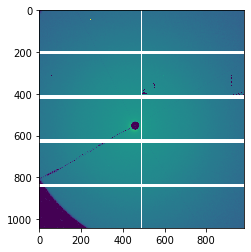

In [7]:
fig, ax = plt.subplots()
ax.imshow(image_Ref, norm=LogNorm())

In [108]:
#x_Center = metaFrame['x_Center'][0]# 456.736 #pix
#y_Center = 556.579 #pix
#directBeamDistance = 801.690 #mm
dist = stDetDist #m
# give the pixel size in meter
pixelsize = 172e-6 #m
energy = 7000 # in eV
#calculate wavelength, scattering angle and sample to detector distance
wavelength = con.h * con.c / con.e / energy  # m
print(energy,'eV correspond to',wavelength*(10**9),'nm','at a distance of',dist,'m')

7000 eV correspond to 0.1771202819948674 nm at a distance of 0.80169 m


In [113]:
# adress the mask
ai = pyFAI.AzimuthalIntegrator(dist=dist, poni1=y_Center*pixelsize, poni2=x_Center *pixelsize,
                               detector=Pilatus1M(), wavelength=wavelength)

ai_mask_path = data_dir + os.sep + 'mask_short.edf'
ai_mask_object = fabio.open(ai_mask_path)
ai_mask = ai_mask_object.data


  File "<ipython-input-113-38ae0fef2851>", line 3, in <module>
    detector=Pilatus1M(), wavelength=wavelength)


In [114]:
# usage of integrate 1d method
bin_number = 400 #how many data points are generated
q, I, e = ai.integrate1d(image_Ref, bin_number, error_model='poisson', mask=ai_mask)

[]

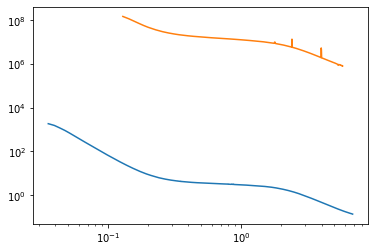

In [27]:
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.fill_between(ref_q, ref_I + scale * ref_e, ref_I - scale * ref_e, alpha=0.5)
ax.plot(ref_q, ref_I)
ax.loglog()

In [45]:
int_Reference0 = integrate.trapz(y=ref0_I ,x=ref0_q, axis=- 1)
int_Reference = integrate.trapz(y=ref_I ,x=ref_q, axis=- 1)
calibrationFactor = int_Reference0/int_Reference
print('known',int_Reference0,'experimental',int_Reference,'factor',calibrationFactor)

known 40.935477858500015 experimental 40584836.82692241 factor 1.0086397053429817e-06


[]

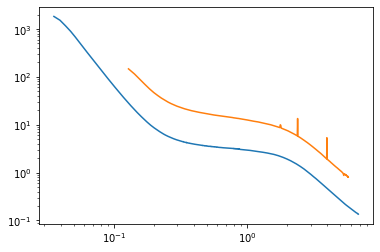

In [47]:
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.plot(ref_q, ref_I*calibrationFactor)
ax.loglog()

In [104]:
# find integration limits for the Reference data
q_Limit_min = np.array((ref0_q.min(),ref_q.min())).max()
q_Limit_max = np.array((ref0_q.max(),ref_q.max())).min()
q_normLimit_min = 2 * q_Limit_min
q_normLimit_max = q_Limit_max - 0.8*q_Limit_max
# find the index close to the limit
ref0_IndexMin = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_min))
ref0_IndexMax = min(range(ref0_q.size), key=lambda i: abs(ref0_q[i]-q_normLimit_max))
ref_IndexMin = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_min))
ref_IndexMax = min(range(ref_q.size), key=lambda i: abs(ref_q[i]-q_normLimit_max))

print('Normalization between:',q_normLimit_min,'nm^-1 and ',q_normLimit_max,'nm^-1')
print('Index for Reference file:',ref0_IndexMin,'with',ref0_q[ref0_IndexMin],'nm^-1 to',ref0_IndexMax,'with',ref0_q[ref0_IndexMax],'nm^-1')
print('Index for Experimental data:',ref_IndexMin,'with',ref_q[ref_IndexMin],'nm^-1 to',ref_IndexMax,'with',ref_q[ref_IndexMax],'nm^-1')

Normalization between: 0.25783793930087684 nm^-1 and  1.150917351633363 nm^-1
Index for Reference file: 56 with 0.2565 nm^-1 to 259 with 1.1473 nm^-1
Index for Experimental data: 9 with 0.25581373179742434 nm^-1 to 72 with 1.1440770668263258 nm^-1


In [105]:
ref0_q[ref0_IndexMin:ref0_IndexMax].size
ref_q[ref_IndexMin:ref_IndexMax].size

int_Reference0 = integrate.trapz(y=ref0_I[ref0_IndexMin:ref0_IndexMax] ,x=ref0_q[ref0_IndexMin:ref0_IndexMax], axis=- 1)
int_Reference = integrate.trapz(y=ref_I[ref_IndexMin:ref_IndexMax] ,x=ref_q[ref_IndexMin:ref_IndexMax], axis=- 1)
calibrationFactor = int_Reference0/int_Reference
print('known',int_Reference0,'experimental',int_Reference,'factor',calibrationFactor)

known 3.705720409 experimental 13755479.46393196 factor 2.6939958136077445e-07


[]

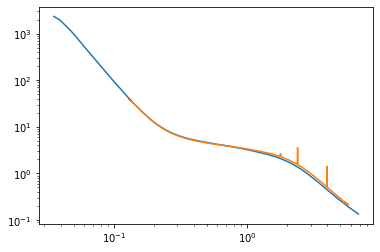

In [106]:
fig, ax = plt.subplots()
ax.plot(ref0_q, ref0_I)
ax.plot(ref_q, ref_I*calibrationFactor)
ax.loglog()

In [151]:
name

'Empty'